In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline 

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset

import torchvision 
import torchvision.transforms as transforms

if torch.cuda.is_available():
    print("My environment is configured to run on the GPU!")
else:
    print("Running on the CPU!")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

My environment is configured to run on the GPU!


### Step 1

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [3]:
from pathlib import Path
from torchvision import datasets

trainset_path = Path('../dataset/train')
trainset_path.mkdir(parents=True, exist_ok=True)

trainset = datasets.MNIST(
    trainset_path, 
    download=True,
    train=True,
    transform=transform,
)

testset_path = Path('../dataset/test')
testset_path.mkdir(parents=True, exist_ok=True)

valset = datasets.MNIST(
    testset_path, 
    download=True,
    train=False,
    transform=transform,
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,
)

valloader = torch.utils.data.DataLoader(
    valset, 
    batch_size=64,
    shuffle=True,
)

### Step 2

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


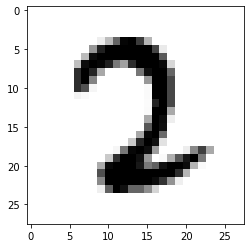

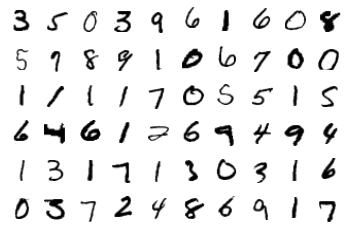

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images+1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Step 3

In [6]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

class Model(nn.Module):
    def __init__(self, d_in: int, d_h1: int, d_h2: int, d_out: int):
        super().__init__()
        self.linear1 = nn.Linear(d_in, d_h1)
        self.linear2 = nn.Linear(d_h1, d_h2)
        self.linear3 = nn.Linear(d_h2, d_out)
    
    def forward(self, x):
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.linear3(x)
        x = nn.ReLU()(x)
        return nn.LogSoftmax(dim=1)(x)

model = Model(input_size, hidden_sizes[0], hidden_sizes[1], output_size).to(device)
print(model)

Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
criterion = nn.NLLLoss().to(device)
images, labels = next(iter(trainloader))
images = images.to(device)
labels = labels.to(device)
images = images.view(images.shape[0], -1)
print(images.shape)

logps = model(images)
loss = criterion(logps, labels)
print(loss)

torch.Size([64, 784])
tensor(2.2966, device='cuda:0', grad_fn=<NllLossBackward>)


### Step 4

In [8]:
print('Before backward pass: \n', list(model.parameters())[0].data)
loss.backward()
print('After backward pass: \n', list(model.parameters())[0].data)

Before backward pass: 
 tensor([[-0.0241, -0.0060,  0.0131,  ..., -0.0258,  0.0349,  0.0268],
        [-0.0163, -0.0017,  0.0113,  ..., -0.0013, -0.0282,  0.0324],
        [-0.0028,  0.0305, -0.0186,  ..., -0.0071, -0.0056, -0.0189],
        ...,
        [ 0.0093,  0.0051, -0.0055,  ...,  0.0324,  0.0269, -0.0132],
        [-0.0067,  0.0146, -0.0148,  ..., -0.0238,  0.0297,  0.0053],
        [ 0.0218,  0.0083, -0.0100,  ...,  0.0021,  0.0275,  0.0156]],
       device='cuda:0')
After backward pass: 
 tensor([[-0.0241, -0.0060,  0.0131,  ..., -0.0258,  0.0349,  0.0268],
        [-0.0163, -0.0017,  0.0113,  ..., -0.0013, -0.0282,  0.0324],
        [-0.0028,  0.0305, -0.0186,  ..., -0.0071, -0.0056, -0.0189],
        ...,
        [ 0.0093,  0.0051, -0.0055,  ...,  0.0324,  0.0269, -0.0132],
        [-0.0067,  0.0146, -0.0148,  ..., -0.0238,  0.0297,  0.0053],
        [ 0.0218,  0.0083, -0.0100,  ...,  0.0021,  0.0275,  0.0156]],
       device='cuda:0')


### Step 5

In [9]:
def get_accuracy(
    predictions: torch.Tensor,
    truths: torch.Tensor,
) -> float:
    return (predictions == truths).sum().item() / float(truths.numel())

In [10]:
from torch import optim
from time import time

optimizer = optim.SGD(
    model.parameters(),
    lr=0.003,
    momentum=0.9,
)

epochs = 20
best_epoch = 0
best_score = None

time0 = time()

for e in range(epochs):
    # train
    model.train()
    train_losses = []
    train_scores = []
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        # flatten images 
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        # backprop
        loss.backward()

        # update parameters
        optimizer.step()

        # for logging
        predictions = output.argmax(dim=1)
        train_losses.append(loss.item())
        train_scores.append(get_accuracy(predictions, labels))
    
    running_loss = sum(train_losses) / len(train_losses)
    running_acc = sum(train_scores) / len(train_scores)
    #print(f"Epoch {e} - Training loss: {running_loss}")

    # validation
    model.eval()
    val_losses = []
    val_accuracies = []
    for images, labels in valloader:
        images = images.to(device)
        images = images.view(images.shape[0], -1)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            predictions = output.argmax(dim=1)
        # loss
        loss = criterion(output, labels)
        val_losses.append(loss.item())
        # accuracy 
        val_accuracies.append(get_accuracy(predictions, labels))
    val_loss = sum(val_losses) / len(val_losses)
    val_accuracy = sum(val_accuracies) / len(val_accuracies)
    if best_score is None or val_accuracy >= best_score:
        best_score = val_accuracy
        best_epoch = e
        torch.save(model.state_dict(), "my_mnist_best_model.pt")
    
    # logging 
    elapsed_minutes = round((time() - time0) / 60, 2)
    log = f'{e}\t{elapsed_minutes}\t{running_loss:.4f}\
        \t{running_acc:.4f}\t{val_loss:.4f}\t{val_accuracy:.4f}'
    if e == 0:
        log = 'Epoch\tTime[m]\tTrainLoss\tTrainAcc\
            \tValLoss\tValAcc\n' + log
    print(log)

print("\nTraining time (in minutes) =", (time() - time0) / 60)

Epoch	Time[m]	TrainLoss	TrainAcc            	ValLoss	ValAcc
0	0.15	1.1807        	0.6274	0.9822	0.6607
1	0.29	0.8308        	0.7150	0.7407	0.7386
2	0.43	0.5822        	0.8021	0.2629	0.9240
3	0.58	0.2309        	0.9343	0.2154	0.9382
4	0.72	0.1805        	0.9477	0.1615	0.9522
5	0.87	0.1471        	0.9567	0.1420	0.9584
6	1.01	0.1286        	0.9630	0.1322	0.9607
7	1.16	0.1115        	0.9674	0.1164	0.9662
8	1.31	0.0987        	0.9714	0.1091	0.9667
9	1.46	0.0888        	0.9736	0.1148	0.9647
10	1.6	0.0801        	0.9761	0.0995	0.9709
11	1.75	0.0736        	0.9780	0.0949	0.9714
12	1.89	0.0650        	0.9809	0.0913	0.9743
13	2.03	0.0597        	0.9825	0.0945	0.9722
14	2.17	0.0560        	0.9826	0.1000	0.9692
15	2.32	0.0510        	0.9847	0.0826	0.9761
16	2.47	0.0472        	0.9857	0.0901	0.9724
17	2.61	0.0439        	0.9870	0.0851	0.9740
18	2.76	0.0408        	0.9876	0.0792	0.9755
19	2.9	0.0379        	0.9889	0.0802	0.9756

Training time (in minutes) = 2.9049394726753235


### Step 6

In [11]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted digit = 5


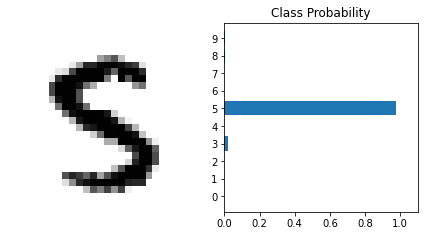

In [12]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
img = img.to(device)

with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [13]:
correct_count, all_count = 0, 0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img.to(device))
        
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if true_label == pred_label:
            correct_count += 1
        all_count += 1

print("Number of images tested =", all_count)
print("\nModel accuracy =", correct_count / all_count)

Number of images tested = 10000

Model accuracy = 0.9755


### Step 7

In [14]:
torch.save(model, 'my_mnist_model.pt')